<a href="https://colab.research.google.com/github/techandy42/bug_in_the_code_stack/blob/main/bug_in_the_code_stack_python_source_code_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bug In The Code Stack - Python Source Code Preprocessing

# Dataset Info

- Dataset used: `python_code_instructions_18k_alpaca`
- [HuggingFace Dataset](https://huggingface.co/datasets/iamtarun/python_code_instructions_18k_alpaca)

# Data Preprocessing

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import pandas as pd

df_alpaca = pd.read_parquet('/content/drive/My Drive/hammingai/Bug_In_The_Code_Stack/datasets/python_code_instructions_18k_alpaca.parquet', engine='pyarrow')
df_alpaca.head()

,instruction,input,output,prompt
0,Create a function to calculate the sum of a se...,"[1, 2, 3, 4, 5]",# Python code\ndef sum_sequence(sequence):\n ...,Below is an instruction that describes a task....
1,Generate a Python code for crawling a website ...,website: www.example.com \ndata to crawl: phon...,import requests\nimport re\n\ndef crawl_websit...,Below is an instruction that describes a task....
2,Create a Python list comprehension to get the ...,,"[x*x for x in [1, 2, 3, 5, 8, 13]]",Below is an instruction that describes a task....
3,Generate a python script to perform this action.,"Given a string, remove all the consecutive dup...",def remove_duplicates(string): \n result = ...,Below is an instruction that describes a task....
4,Write a python script to generates random numb...,,def generate_random_divisible_number():\n i...,Below is an instruction that describes a task....


In [66]:
!pip install pyflakes

In [67]:
import sys
from pyflakes.api import check
from pyflakes.reporter import Reporter
from io import StringIO

def check_syntax(code):
    # Store the original stdout and stderr
    original_stdout = sys.stdout
    original_stderr = sys.stderr

    try:
        # Dummy output streams to capture the check outputs
        out_stream = StringIO()
        err_stream = StringIO()

        # Custom reporter to redirect output to StringIO objects
        reporter = Reporter(out_stream, err_stream)

        # Check the code; 0 means no errors, 1 means some errors were found
        result = check(code, filename='<string>', reporter=reporter)

        # True if no errors, False if there are errors
        return result == 0

    finally:
        # Restore the original stdout and stderr
        sys.stdout = original_stdout
        sys.stderr = original_stderr

In [68]:
from tqdm import tqdm

error_idx = []

for i in tqdm(range(len(df_alpaca))):
    code = df_alpaca['output'][i]
    syntactic_error = check_syntax(code)
    if not syntactic_error:
        error_idx.append(i)

100%|██████████| 18612/18612 [00:24<00:00, 759.26it/s]


In [69]:
print(f"{len(error_idx)} items have syntactic errors...")

4715 items have syntactic errors...


In [70]:
for idx in error_idx[:3]:
    print(f"{idx}:")
    print(df_alpaca['output'][idx])
    print()

6:
from flask import Flask, request
from flask_sqlalchemy import SQLAlchemy

app = Flask(name)
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:////tmp/test.db'
db = SQLAlchemy(app)

class Record(db.Model):
 id = db.Column(db.Integer, primary_key=True)
 name = db.Column(db.String(120), unique=True)

db.create_all()

@app.route('/records', methods=['GET'])
def get_records():
 records = Record.query.all()
 return {'records':[record.name for record in records]}

@app.route('/records', methods=['POST'])
def create_record():
 record = Record(name=request.json['name'])
 db.session.add(record)
 db.session.commit()
 return {'id': record.id}

@app.route('/records/int:id', methods=['PUT'])
def update_record(id):
 record = Record.query.get(id)
 record.name = request.json['name']
 db.session.commit()
 return {'message': 'Record updated'}

@app.route('/records/int:id', methods=['DELETE'])
def delete_record(id):
 Record.query.filter_by(id=id).delete()
 db.session.commit()
 return {'message': 'Record 

In [71]:
all_idx = list(df_alpaca.index)
error_idx_set = set(error_idx)
valid_idx = [idx for idx in all_idx if idx not in error_idx_set]
len(valid_idx)

13897

In [72]:
!pip install tiktoken

In [73]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [74]:
token_counts = [num_tokens_from_string(output, 'cl100k_base') for output in df_alpaca['output'][valid_idx]]

In [75]:
idx_and_token_counts = list(zip(valid_idx, token_counts))

In [76]:
filtered_idx_and_token_counts = [(idx, count) for idx, count in idx_and_token_counts if 20 <= count <= 50]

In [77]:
len(filtered_idx_and_token_counts)

4010

In [78]:
filtered_idx = [idx for idx, _ in filtered_idx_and_token_counts]
filtered_token_counts = [count for _, count in filtered_idx_and_token_counts]

In [79]:
print(f"Total Token: {sum(filtered_token_counts)}")

Total Token: 142996


In [80]:
print(f"Avg Token: {sum(filtered_token_counts) / len(filtered_token_counts):.2f}")

Avg Token: 35.66


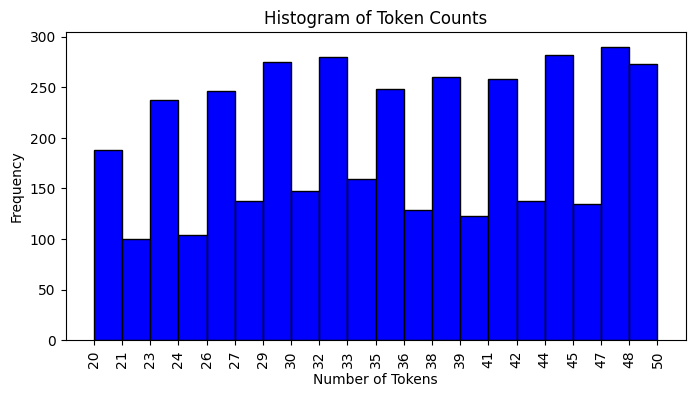

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Define the maximum number of bins (no more than 20)
max_bins = 20

# Calculate the appropriate number of bins within the limit
max_tokens = max(filtered_token_counts)
min_tokens = min(filtered_token_counts)
range_tokens = max_tokens - min_tokens
number_of_bins = min(range_tokens + 1, max_bins)

# Calculate bin edges
bin_edges = np.linspace(min_tokens, max_tokens, number_of_bins + 1)

# Create the histogram with dynamically calculated bins
plt.figure(figsize=(8, 4))
plt.hist(filtered_token_counts, bins=bin_edges, color='blue', edgecolor='black', align='mid')
plt.title('Histogram of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

# Format x-axis
plt.xticks(bin_edges, [f"{int(edge)}" for edge in bin_edges], rotation='vertical')

# Show the plot
plt.show()

In [82]:
df_alpaca_filtered = df_alpaca.iloc[filtered_idx].copy(deep=True)

In [83]:
len(df_alpaca_filtered)

4010

In [84]:
df_alpaca_filtered.head()

,instruction,input,output,prompt
0,Create a function to calculate the sum of a se...,"[1, 2, 3, 4, 5]",# Python code\ndef sum_sequence(sequence):\n ...,Below is an instruction that describes a task....
2,Create a Python list comprehension to get the ...,,"[x*x for x in [1, 2, 3, 5, 8, 13]]",Below is an instruction that describes a task....
8,What should this Python program do?,def is_palindrome(s):\n '''Write your code ...,def is_palindrome(s):\n '''This function re...,Below is an instruction that describes a task....
10,Generate a Python program that adds two then d...,,"def double_add(num1, num2): \n return (num1...",Below is an instruction that describes a task....
16,Write a Python program to find all the numbers...,"int m=36, int n=74, int divisor=6","def find_numbers_divisible_by(m, n, divisor):\...",Below is an instruction that describes a task....


# Creating Background Text & Needle (a.k.a. Syntactic Bug)

### Different Types of Syntactic Errors

### Missing

> Missing Colons

```python
def bar(cond)
  if cond:
    return True
  return False
```

> Missing Parenthesis

```python
def bar(cond:
  if cond:
    return True
  return False
```

> Missing Quotations

```python
var = "hello world
```

> Missing Commas

```
lst = [1, 2 3]
```

### Mismatch

> Mismatched String Delimiter

```python
var = "hello world'
```

> Mismatched Parentheses, Brackets, or Braces

```python
lst = [(1, 2}, {'items': [3, 4]}]
```

### Keywords

> Keywords as Identifiers

```python
if = "val"
```

In [85]:
# Removes the first colon that causes syntactic error
def missing_colon(code):
    import re
    # Split the code into lines
    lines = code.split('\n')
    modified_code = code  # Initial state, no modifications

    # Iterate through each line, checking for function or control structure lines that end with a colon
    for i, line in enumerate(lines):
        # The regex matches lines that end with a colon after a control structure or function declaration
        match = re.search(r"^\s*(def|if|else|for|while|with|try|except|finally)\b.*:$", line)
        if match:
            # Temporarily remove the colon to check for syntax errors
            temp_code = line[:match.end()-1] + line[match.end():]
            # Check the modified line for syntax errors
            if not check_syntax(temp_code):
                # Modify the original code with the colon removed at this line if it causes a syntax error
                modified_code = '\n'.join(lines[:i] + [temp_code] + lines[i+1:])
                return True, modified_code, i + 1  # Return modified code with just this one syntax error causing change

    # If no syntax error causing colon removals were found, return the original unmodified code
    return False, modified_code, -1

if __name__ == "__main__":
  # Example usage
  code = """def bar(cond):
  if cond:
    return True
  return False"""

  print("=" * 10 + " Test 1 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = missing_colon(code)
  if modified:
      print(f"A colon removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No colon removed.")

  print("=" * 28)
  print()

  code = """# : in a comment
def bar(cond):
  if cond:
    return True
  return False
# : in a comment"""

  print("=" * 10 + " Test 2 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = missing_colon(code)
  if modified:
      print(f"A colon removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No colon removed.")

  print("=" * 28)
  print()

  code = """var = \": in a string\"
def bar(cond):
  if cond:
    return True
  return False
var = \": in a string\""""

  print("=" * 10 + " Test 3 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = missing_colon(code)
  if modified:
      print(f"A colon removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No colon removed.")

  print("=" * 28)
  print()

========== Test 1 ==========
Original (contains no bug):
def bar(cond):
  if cond:
    return True
  return False

A colon removed (contains bug) at line 1:
def bar(cond)
  if cond:
    return True
  return False

========== Test 2 ==========
Original (contains no bug):
# : in a comment
def bar(cond):
  if cond:
    return True
  return False
# : in a comment

A colon removed (contains bug) at line 2:
# : in a comment
def bar(cond)
  if cond:
    return True
  return False
# : in a comment

========== Test 3 ==========
Original (contains no bug):
var = ": in a string"
def bar(cond):
  if cond:
    return True
  return False
var = ": in a string"

A colon removed (contains bug) at line 2:
var = ": in a string"
def bar(cond)
  if cond:
    return True
  return False
var = ": in a string"



In [86]:
def missing_parenthesis(code):
    import re
    # Split the code into lines
    lines = code.split('\n')
    modified_code = code  # Start with the original code

    # Iterate through each line, looking for lines that contain a closing parenthesis
    for i, line in enumerate(lines):
        # Find all occurrences of ')' in the line
        matches = [m.start() for m in re.finditer(r"\)", line)]
        if matches:
            # Iterate over each found position of ')', without needing to reverse the list
            for match in matches:
                # Temporarily remove one closing parenthesis at a time
                temp_code = line[:match] + line[match+1:]
                temp_line = '\n'.join(lines[:i] + [temp_code] + lines[i+1:])
                # Check the modified line for syntax errors
                if not check_syntax(temp_line):
                    # Modify the original code with the parenthesis removed at this position if it causes a syntax error
                    modified_code = temp_line
                    return True, modified_code, i + 1  # Return modified code with just this one syntax error causing change

    # If no syntax error causing parenthesis removals were found, return the original unmodified code
    return False, modified_code, -1

if __name__ == "__main__":
  # Example usage
  code = """def bar(cond):
  if (cond == True):
    return True
  return False"""

  print("=" * 10 + " Test 1 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = missing_parenthesis(code)
  if modified:
      print(f"A right parenthesis removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No right parenthesis removed.")

  print("=" * 28)
  print()

  code = """# ) in a comment
def bar(cond):
  if (cond == True):
    return True
  return False
# ) in a comment"""

  print("=" * 10 + " Test 2 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = missing_parenthesis(code)
  if modified:
      print(f"A right parenthesis removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No right parenthesis removed.")

  print("=" * 28)
  print()

  code = """var = \") in a string\"
def bar(cond):
  if (cond == True):
    return True
  return False
var = \") in a string\""""

  print("=" * 10 + " Test 3 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = missing_parenthesis(code)
  if modified:
      print(f"A right parenthesis removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No right parenthesis removed.")

  print("=" * 28)
  print()

========== Test 1 ==========
Original (contains no bug):
def bar(cond):
  if (cond == True):
    return True
  return False

A right parenthesis removed (contains bug) at line 1:
def bar(cond:
  if (cond == True):
    return True
  return False

========== Test 2 ==========
Original (contains no bug):
# ) in a comment
def bar(cond):
  if (cond == True):
    return True
  return False
# ) in a comment

A right parenthesis removed (contains bug) at line 2:
# ) in a comment
def bar(cond:
  if (cond == True):
    return True
  return False
# ) in a comment

========== Test 3 ==========
Original (contains no bug):
var = ") in a string"
def bar(cond):
  if (cond == True):
    return True
  return False
var = ") in a string"

A right parenthesis removed (contains bug) at line 2:
var = ") in a string"
def bar(cond:
  if (cond == True):
    return True
  return False
var = ") in a string"



In [87]:
def missing_quotation(code):
    import re
    # Split the code into lines
    lines = code.split('\n')
    modified_code = code  # Initial state, no modifications

    # Iterate through each line, looking for lines that contain a quotation mark
    for i, line in enumerate(lines):
        # Find all occurrences of single or double quotes in the line
        matches = [m.start() for m in re.finditer(r"[\'\"]", line)]
        if matches:
            # Check only even indexed occurrences (i.e., 2nd, 4th, 6th, ...) by removing it and checking for syntax errors
            # Since list indexing is zero-based, we consider the even indices to be 1, 3, 5, ..., which are the 2nd, 4th, 6th quotations
            for match in matches[1::2]:  # Start from the second match and skip every other match
                # Temporarily remove the quotation mark at this position
                temp_code = line[:match] + line[match+1:]
                temp_line = '\n'.join(lines[:i] + [temp_code] + lines[i+1:])
                # Check the modified line for syntax errors
                if not check_syntax(temp_line):
                    # Modify the original code with the quotation removed at this position if it causes a syntax error
                    modified_code = temp_line
                    return True, modified_code, i + 1  # Return modified code with just this one syntax error causing change

    # If no syntax error causing quotation removals were found, return the original unmodified code
    return False, modified_code, -1

if __name__ == "__main__":
  # Example usage
  code = """var = \"hello world\""""

  print("=" * 10 + " Test 1 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = missing_quotation(code)
  if modified:
      print(f"A closing quotation removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No closing quotation removed.")

  print("=" * 28)
  print()

  code = """# ' and " in the comment
var1 = 'hello world1'
var2 = "hello world2"
# ' and " in the comment"""

  print("=" * 10 + " Test 2 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = missing_quotation(code)
  if modified:
      print(f"A closing quotation removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No closing quotation removed.")

  print("=" * 28)
  print()

  code = """var = \"'hello world'\""""

  print("=" * 10 + " Test 3 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = missing_quotation(code)
  if modified:
      print(f"A closing quotation removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No closing quotation removed.")

  print("=" * 28)
  print()

========== Test 1 ==========
Original (contains no bug):
var = "hello world"

A closing quotation removed (contains bug) at line 1:
var = "hello world

========== Test 2 ==========
Original (contains no bug):
# ' and " in the comment
var1 = 'hello world1'
var2 = "hello world2"
# ' and " in the comment

A closing quotation removed (contains bug) at line 2:
# ' and " in the comment
var1 = 'hello world1
var2 = "hello world2"
# ' and " in the comment

========== Test 3 ==========
Original (contains no bug):
var = "'hello world'"

A closing quotation removed (contains bug) at line 1:
var = "'hello world'



In [88]:
def missing_comma(code):
    import re
    # Split the code into lines
    lines = code.split('\n')
    modified_code = code  # Start with the original code

    # Iterate through each line, looking for lines that contain a comma
    for i, line in enumerate(lines):
        # Find all occurrences of commas in the line
        matches = [m.start() for m in re.finditer(r",", line)]
        if matches:
            # Check each occurrence by removing it and checking for syntax errors
            for match in matches:  # Iterate through matches without reversing
                # Temporarily remove one comma at a time
                temp_code = line[:match] + line[match+1:]
                temp_line = '\n'.join(lines[:i] + [temp_code] + lines[i+1:])
                # Check the modified line for syntax errors
                if not check_syntax(temp_line):
                    # Modify the original code with the comma removed at this position if it causes a syntax error
                    modified_code = temp_line
                    return True, modified_code, i + 1  # Return modified code with just this one syntax error causing change

    # If no syntax error causing comma removals were found, return the original unmodified code
    return False, modified_code, -1

if __name__ == "__main__":
  # Example usage
  code = """lst = [1, 2, 3]"""

  print("=" * 10 + " Test 1 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = missing_comma(code)
  if modified:
      print(f"A comma removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No comma removed.")

  print("=" * 28)
  print()

  code = """# , in the comment
def foo(a, b, c):
  return True
# , in the comment"""

  print("=" * 10 + " Test 2 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = missing_comma(code)
  if modified:
      print(f"A comma removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No comma removed.")

  print("=" * 28)
  print()

  code = """s = \", in the comment\"
def foo(a, b, c):
  return True
s = \", in the comment\""""

  print("=" * 10 + " Test 3 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = missing_comma(code)
  if modified:
      print(f"A comma removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No comma removed.")

  print("=" * 28)
  print()

========== Test 1 ==========
Original (contains no bug):
lst = [1, 2, 3]

A comma removed (contains bug) at line 1:
lst = [1 2, 3]

========== Test 2 ==========
Original (contains no bug):
# , in the comment
def foo(a, b, c):
  return True
# , in the comment

A comma removed (contains bug) at line 2:
# , in the comment
def foo(a b, c):
  return True
# , in the comment

========== Test 3 ==========
Original (contains no bug):
s = ", in the comment"
def foo(a, b, c):
  return True
s = ", in the comment"

A comma removed (contains bug) at line 2:
s = ", in the comment"
def foo(a b, c):
  return True
s = ", in the comment"



In [89]:
def mismatched_quotation(code):
    import re
    # Split the code into lines
    lines = code.split('\n')
    modified_code = code  # Start with the original code
    modification_made = False  # Track if any modification has been made

    # Iterate through each line, looking for lines that contain a quotation mark
    for i, line in enumerate(lines):
        # Find all occurrences of single or double quotes in the line
        matches = [(m.start(), m.group()) for m in re.finditer(r"[\'\"]", line)]
        if matches:
            # Only consider the 2nd, 4th, 6th, etc., instances of quotation marks
            for index in range(1, len(matches), 2):  # Start from the second match and skip every other match
                match, char = matches[index]
                # Determine the replacement character
                new_char = '"' if char == "'" else "'"
                # Replace the character in the line
                temp_code = line[:match] + new_char + line[match+1:]
                temp_line = '\n'.join(lines[:i] + [temp_code] + lines[i+1:])
                # Check the modified line for syntax errors
                if not check_syntax(temp_line):
                    # Modify the original code with the quotation replaced at this position if it causes a syntax error
                    modified_code = temp_line
                    return True, modified_code, i + 1  # Return modified code with just this one syntax error causing change

    # If no syntax error causing quotation replacements were found, return the original unmodified code, unchanged state, and line index -1
    return False, modified_code, -1

if __name__ == "__main__":
  # Example usage
  code = """var = \"hello world\""""

  print("=" * 10 + " Test 1 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = mismatched_quotation(code)
  if modified:
      print(f"A mismatched quotation (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No mismatched quotation.")

  print("=" * 28)
  print()

  code = """# '' and "" in the comment
var1 = 'hello world1'
var2 = "hello world2"
# '' and "" in the commen"""

  print("=" * 10 + " Test 2 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = mismatched_quotation(code)
  if modified:
      print(f"A mismatched quotation (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No mismatched quotation.")

  print("=" * 28)
  print()

  code = """var = \"'hello world'\""""

  print("=" * 10 + " Test 3 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = mismatched_quotation(code)
  if modified:
      print(f"A mismatched quotation (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No mismatched quotation.")

  print("=" * 28)
  print()

  code = """var = \"'\"hello world\"'\""""

  print("=" * 10 + " Test 4 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = mismatched_quotation(code)
  if modified:
      print(f"A mismatched quotation (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No mismatched quotation.")

  print("=" * 28)
  print()

  code = """var = \"hello\" + 'world'"""

  print("=" * 10 + " Test 5 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = mismatched_quotation(code)
  if modified:
      print(f"A mismatched quotation (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No mismatched quotation.")

  print("=" * 28)
  print()

  code = """var = \"\"\"'hello world'\"\"\""""

  print("=" * 10 + " Test 6 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = mismatched_quotation(code)
  if modified:
      print(f"A mismatched quotation (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No mismatched quotation.")

  print("=" * 28)
  print()

========== Test 1 ==========
Original (contains no bug):
var = "hello world"

A mismatched quotation (contains bug) at line 1:
var = "hello world'

========== Test 2 ==========
Original (contains no bug):
# '' and "" in the comment
var1 = 'hello world1'
var2 = "hello world2"
# '' and "" in the commen

A mismatched quotation (contains bug) at line 2:
# '' and "" in the comment
var1 = 'hello world1"
var2 = "hello world2"
# '' and "" in the commen

========== Test 3 ==========
Original (contains no bug):
var = "'hello world'"

A mismatched quotation (contains bug) at line 1:
var = ""hello world'"

========== Test 4 ==========
Original (contains bug):
var = "'"hello world"'"

A mismatched quotation (contains bug) at line 1:
var = """hello world"'"

========== Test 5 ==========
Original (contains no bug):
var = "hello" + 'world'

A mismatched quotation (contains bug) at line 1:
var = "hello' + 'world'

========== Test 6 ==========
Original (contains no bug):
var = """'hello world'"""

A mis

In [90]:
import random
import re

def mismatched_bracket(code):
    # Define the mapping of brackets for random replacement
    bracket_map = {
        ')': [']', '}'],
        ']': [')', '}'],
        '}': [')', ']']
    }

    # Split the code into lines
    lines = code.split('\n')
    modified_code = code  # Start with the original code
    modification_made = False  # Track if any modification has been made

    # Iterate through each line, looking for lines that contain a closing bracket
    for i, line in enumerate(lines):
        # Find all occurrences of ')', ']', '}'
        matches = [(m.start(), m.group()) for m in re.finditer(r"[)\]}]", line)]
        if matches:
            # Iterate over each found position of a bracket
            for match, bracket in matches:
                # Choose a random replacement bracket from the mapping
                new_bracket = random.choice(bracket_map[bracket])
                # Replace the bracket in the line
                temp_code = line[:match] + new_bracket + line[match+1:]
                temp_line = '\n'.join(lines[:i] + [temp_code] + lines[i+1:])
                # Check the modified line for syntax errors
                if not check_syntax(temp_line):
                    # Modify the original code with the bracket replaced at this position if it causes a syntax error
                    modified_code = temp_line
                    modification_made = True
                    return True, modified_code, i + 1  # Return modified code with just this one syntax error causing change

    # If no syntax error causing bracket replacements were found, return the original unmodified code, unchanged state, and line index -1
    return False, modified_code, -1

if __name__ == "__main__":
  # Example usage
  code = """lst = [(1, 2), {'items': [3, 4]}]"""

  print("=" * 10 + " Test 1 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = mismatched_bracket(code)
  if modified:
      print(f"A mismatched bracket (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No right parenthesis removed.")

  print("=" * 28)
  print()

  code = """# () [] {} in a comment
def bar(foo):
  if foo == []:
    return True
  return False
# () [] {} in a comment"""

  print("=" * 10 + " Test 2 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = mismatched_bracket(code)
  if modified:
      print(f"A mismatched bracket removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No right parenthesis removed.")

  print("=" * 28)
  print()

  code = """var = \"() [] {} in a comment\"
def bar(foo):
  if foo == []:
    return True
  return False
var = \"() [] {} in a comment\""""

  print("=" * 10 + " Test 3 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = mismatched_bracket(code)
  if modified:
      print(f"A mismatched bracket removed (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No right parenthesis removed.")

  print("=" * 28)
  print()

========== Test 1 ==========
Original (contains no bug):
lst = [(1, 2), {'items': [3, 4]}]

A mismatched bracket (contains bug) at line 1:
lst = [(1, 2], {'items': [3, 4]}]

========== Test 2 ==========
Original (contains no bug):
# () [] {} in a comment
def bar(foo):
  if foo == []:
    return True
  return False
# () [] {} in a comment

A mismatched bracket removed (contains bug) at line 2:
# () [] {} in a comment
def bar(foo}:
  if foo == []:
    return True
  return False
# () [] {} in a comment

========== Test 3 ==========
Original (contains no bug):
var = "() [] {} in a comment"
def bar(foo):
  if foo == []:
    return True
  return False
var = "() [] {} in a comment"

A mismatched bracket removed (contains bug) at line 2:
var = "() [] {} in a comment"
def bar(foo}:
  if foo == []:
    return True
  return False
var = "() [] {} in a comment"



In [91]:
import tokenize
import io

def extract_imported_identifiers(code):
    # Prepare to tokenize
    stream = io.BytesIO(code.encode('utf-8'))
    tokens = list(tokenize.tokenize(stream.readline))

    imported_identifiers = []  # List to store imported identifiers
    capture = False  # Flag to indicate we are on an import line

    for toktype, tokval, _, _, _ in tokens:
        if toktype == tokenize.NAME:
            if tokval in ['import', 'from', 'as']:
                # If 'import', 'from', 'as' is encountered, enable capture
                capture = True
            elif capture:
                # Capture any NAME token that appears on an import line
                imported_identifiers.append(tokval)
        elif toktype == tokenize.OP and tokval in [',']:
            # Continue capturing if we see commas in import statements
            continue
        elif toktype in [tokenize.NEWLINE, tokenize.NL, tokenize.ENDMARKER]:
            # Disable capture when the line ends
            capture = False

    return imported_identifiers

# Example usage:
code_example = """
import sys
from os import path, environ
import numpy as np

x = np.array([1, 2, 3])
sys.stdout.write(x)
"""
print(extract_imported_identifiers(code_example))

['sys', 'os', 'path', 'environ', 'numpy', 'np']


In [92]:
import tokenize
import io
import random
import keyword

def keywords_as_identifier(code):
    try:
      # Get a list of Python keywords that are not legal as identifiers
      python_keywords = keyword.kwlist

      # Read the code as bytes, since tokenize requires byte-stream input
      stream = io.BytesIO(code.encode('utf-8'))
      tokens = list(tokenize.tokenize(stream.readline))  # Tokenize the code
      modified_code = code  # Start with the original code

      imported_identifiers = extract_imported_identifiers(code)

      # Filter and collect identifiers that are not keywords, ensuring they are processed in order
      identifiers = [(tok.start[0], tok.start[1], tok.string) for tok in tokens
                    if tok.type == tokenize.NAME and not keyword.iskeyword(tok.string) and tok.string not in imported_identifiers]

      # Process identifiers from first to last
      for line, start, identifier in identifiers:
          # Create a filtered list of keywords that are not the current identifier
          valid_keywords = [kw for kw in python_keywords if kw != identifier]
          if valid_keywords:
              # Choose a random keyword from the valid list
              rand_keyword = random.choice(valid_keywords)
              # Create a modified version of the code by replacing the identifier with the keyword
              lines = modified_code.split('\n')
              old_line = lines[line - 1]
              new_line = old_line[:start] + rand_keyword + old_line[start + len(identifier):]
              lines[line - 1] = new_line
              modified_code = '\n'.join(lines)  # Update modified_code each iteration

              # Check the modified code for syntax errors
              if not check_syntax(modified_code):
                  # If syntax error occurs, return the modified code
                  return True, modified_code, line

      # If no syntax error causing replacements were found, return the original unmodified code
      return False, modified_code, -1
    except Exception as e:
      print(f"Error: {e}")
      return False, code, -1

if __name__ == "__main__":
  # Example usage
  code = """var = \"val\""""

  print("=" * 10 + " Test 1 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = keywords_as_identifier(code)
  if modified:
      print(f"A keyword as identifier (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No keyword as identifier.")

  print("=" * 28)
  print()

  code = """# var1 = \"val1\"
import os
import numpy as np

def bar(cond):
  if cond:
    return True
  return False
x = "hi"
y = "bye"
# var2 = \"val2\""""

  print("=" * 10 + " Test 2 " + "=" * 10)

  print(f"Original (contains {'no bug' if check_syntax(code) else 'bug'}):")
  print(code)
  print()

  modified, new_code, line_number = keywords_as_identifier(code)
  if modified:
      print(f"A keyword as identifier (contains bug) at line {line_number}:")
      print(new_code)
  else:
      print("No keyword as identifier.")

  print("=" * 28)
  print()

========== Test 1 ==========
Original (contains no bug):
var = "val"

A keyword as identifier (contains bug) at line 1:
del = "val"

========== Test 2 ==========
Original (contains bug):
# var1 = "val1"
import os
import numpy as np

def bar(cond):
  if cond:
    return True
  return False
x = "hi"
y = "bye"
# var2 = "val2"

A keyword as identifier (contains bug) at line 5:
# var1 = "val1"
import os
import numpy as np

def for(cond):
  if cond:
    return True
  return False
x = "hi"
y = "bye"
# var2 = "val2"



In [93]:
# If you want to drop existing columns and start again
# df_alpaca_filtered.drop(['output_missing_colon', 'bug_line_number_missing_colon'], axis=1, inplace=True)

In [94]:
# Apply the function and expand the results into new columns
df_alpaca_filtered[['modified', 'new_code', 'line_number']] = df_alpaca_filtered['output'].apply(missing_colon).apply(pd.Series)

# Filter the DataFrame based on the bool column and create new columns
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'output_missing_colon'] = df_alpaca_filtered['new_code']
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'bug_line_number_missing_colon'] = df_alpaca_filtered['line_number']

# Drop the intermediary columns
df_alpaca_filtered.drop(['modified', 'new_code', 'line_number'], axis=1, inplace=True)

In [95]:
random_idx = [random.randint(0, len(df_alpaca_filtered) - 1) for _ in range(3)]

for i in random_idx:
  print(f"Output {i+1}, missing colon error at line {df_alpaca_filtered.iloc[i]['bug_line_number_missing_colon']}:")
  print(df_alpaca_filtered.iloc[i]['output_missing_colon'])
  print()

Output 986, missing colon error at line 1.0:
def find_max(list)
    max_num = list[0]
    for num in list:
        if num > max_num:
            max_num = num
    return max_num

max_number = find_max(list)
print(max_number)

Output 4009, missing colon error at line 2.0:
class Counter:
 def __init__(self)
  self.count = 0
 
 def increment(self):
  self.count += 1
 
 def get_count(self):
  return self.count

Output 3560, missing colon error at line 3.0:
def make_dict_from_list(list_key): 
    dictionary = {}
    for element in list_key
        dictionary[element] = []
    return dictionary



In [96]:
# If you want to drop existing columns and start again
# df_alpaca_filtered.drop(['output_missing_parenthesis', 'bug_line_number_missing_parenthesis'], axis=1, inplace=True)

In [97]:
# Apply the function and expand the results into new columns
df_alpaca_filtered[['modified', 'new_code', 'line_number']] = df_alpaca_filtered['output'].apply(missing_parenthesis).apply(pd.Series)

# Filter the DataFrame based on the bool column and create new columns
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'output_missing_parenthesis'] = df_alpaca_filtered['new_code']
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'bug_line_number_missing_parenthesis'] = df_alpaca_filtered['line_number']

# Drop the intermediary columns
df_alpaca_filtered.drop(['modified', 'new_code', 'line_number'], axis=1, inplace=True)

In [98]:
import random

random_idx = [random.randint(0, len(df_alpaca_filtered) - 1) for _ in range(3)]

for i in random_idx:
  print(f"Output {i+1}, missing parenthesis error at line {df_alpaca_filtered.iloc[i]['bug_line_number_missing_parenthesis']}:")
  print(df_alpaca_filtered.iloc[i]['output_missing_parenthesis'])
  print()

Output 3152, missing parenthesis error at line 2.0:
x = 0
for i in range(0,10000,2:
    x += i
x *= 2
x += (10000 - 1)

Output 2909, missing parenthesis error at line 3.0:
import base64

def encodeInBase64(msg:
    msg_bytes = msg.encode('ascii')
    base64_bytes = base64.b64encode(msg_bytes)
    base64_message = base64_bytes.decode('ascii')

    return base64_message

Output 2535, missing parenthesis error at line 3.0:
import re

def is_valid_phone_number(phone_number:
 pattern = re.compile("^[0-9]{3}-[0-9]{3}-[0-9]{4}$")
 match = pattern.match(phone_number)
 return bool(match)



In [99]:
# If you want to drop existing columns and start again
# df_alpaca_filtered.drop(['output_missing_quotation', 'bug_line_number_missing_quotation'], axis=1, inplace=True)

In [100]:
# Apply the function and expand the results into new columns
df_alpaca_filtered[['modified', 'new_code', 'line_number']] = df_alpaca_filtered['output'].apply(missing_quotation).apply(pd.Series)

# Filter the DataFrame based on the bool column and create new columns
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'output_missing_quotation'] = df_alpaca_filtered['new_code']
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'bug_line_number_missing_quotation'] = df_alpaca_filtered['line_number']

# Drop the intermediary columns
df_alpaca_filtered.drop(['modified', 'new_code', 'line_number'], axis=1, inplace=True)

In [101]:
import random

random_idx = [random.randint(0, len(df_alpaca_filtered) - 1) for _ in range(3)]

for i in random_idx:
  print(f"Output {i+1}, missing quotation error at line {df_alpaca_filtered.iloc[i]['bug_line_number_missing_quotation']}:")
  print(df_alpaca_filtered.iloc[i]['output_missing_quotation'])
  print()

Output 2523, missing quotation error at line nan:
nan

Output 1569, missing quotation error at line 1.0:
my_string = "This is a sentence with five words.
words = my_string.split(" ")
print(len(words))

Output 2369, missing quotation error at line 2.0:
def create_acronym(sentence):
    acronym = '
    words = sentence.split(' ')
    for word in words:
        acronym += word[0].upper()
    return acronym



In [102]:
# If you want to drop existing columns and start again
# df_alpaca_filtered.drop(['output_missing_comma', 'bug_line_number_missing_comma'], axis=1, inplace=True)

In [103]:
# Apply the function and expand the results into new columns
df_alpaca_filtered[['modified', 'new_code', 'line_number']] = df_alpaca_filtered['output'].apply(missing_comma).apply(pd.Series)

# Filter the DataFrame based on the bool column and create new columns
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'output_missing_comma'] = df_alpaca_filtered['new_code']
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'bug_line_number_missing_comma'] = df_alpaca_filtered['line_number']

# Drop the intermediary columns
df_alpaca_filtered.drop(['modified', 'new_code', 'line_number'], axis=1, inplace=True)

In [104]:
import random

random_idx = [random.randint(0, len(df_alpaca_filtered) - 1) for _ in range(3)]

for i in random_idx:
  print(f"Output {i+1}, missing comma error at line {df_alpaca_filtered.iloc[i]['bug_line_number_missing_comma']}:")
  print(df_alpaca_filtered.iloc[i]['output_missing_comma'])
  print()

Output 1833, missing comma error at line 5.0:
str = "Hello, World!"

# loop to iterate through string
for i in range(len(str)-1, -1, -1):
  print(str[i]end="")

print()

Output 3048, missing comma error at line 1.0:
def is_in_range(n start, end):
  if n >= start and n <= end:
    return True
  else:
    return False

Output 2227, missing comma error at line nan:
nan



In [105]:
# If you want to drop existing columns and start again
# df_alpaca_filtered.drop(['output_mismatched_quotation', 'bug_line_number_mismatched_quotation'], axis=1, inplace=True)

In [106]:
# Apply the function and expand the results into new columns
df_alpaca_filtered[['modified', 'new_code', 'line_number']] = df_alpaca_filtered['output'].apply(mismatched_quotation).apply(pd.Series)

# Filter the DataFrame based on the bool column and create new columns
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'output_mismatched_quotation'] = df_alpaca_filtered['new_code']
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'bug_line_number_mismatched_quotation'] = df_alpaca_filtered['line_number']

# Drop the intermediary columns
df_alpaca_filtered.drop(['modified', 'new_code', 'line_number'], axis=1, inplace=True)

In [107]:
import random

random_idx = [random.randint(0, len(df_alpaca_filtered) - 1) for _ in range(3)]

for i in random_idx:
  print(f"Output {i+1}, mismatched quotation error at line {df_alpaca_filtered.iloc[i]['bug_line_number_mismatched_quotation']}:")
  print(df_alpaca_filtered.iloc[i]['output_mismatched_quotation'])
  print()

Output 1734, mismatched quotation error at line nan:
nan

Output 671, mismatched quotation error at line 5.0:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

model = Pipeline([('tfidf", TfidfVectorizer()),
                  ('clf', LogisticRegression())])

Output 1688, mismatched quotation error at line nan:
nan



In [108]:
# If you want to drop existing columns and start again
# df_alpaca_filtered.drop(['output_mismatched_bracket', 'bug_line_number_mismatched_bracket'], axis=1, inplace=True)

In [109]:
# Apply the function and expand the results into new columns
df_alpaca_filtered[['modified', 'new_code', 'line_number']] = df_alpaca_filtered['output'].apply(mismatched_bracket).apply(pd.Series)

# Filter the DataFrame based on the bool column and create new columns
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'output_mismatched_bracket'] = df_alpaca_filtered['new_code']
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'bug_line_number_mismatched_bracket'] = df_alpaca_filtered['line_number']

# Drop the intermediary columns
df_alpaca_filtered.drop(['modified', 'new_code', 'line_number'], axis=1, inplace=True)

In [110]:
import random

random_idx = [random.randint(0, len(df_alpaca_filtered) - 1) for _ in range(3)]

for i in random_idx:
  print(f"Output {i+1}, mismatched bracket error at line {df_alpaca_filtered.iloc[i]['bug_line_number_mismatched_bracket']}:")
  print(df_alpaca_filtered.iloc[i]['output_mismatched_bracket'])
  print()

Output 2769, mismatched bracket error at line 1.0:
def divisible_five(nums}:
    result = []
    for num in nums:
        if num % 5 == 0:
            result.append(num)
    return result

Output 186, mismatched bracket error at line 4.0:
import detect_language

text = "Bonjour tout le monde"
language = detect_language.detect(text]
print(language) # fr

Output 3558, mismatched bracket error at line 1.0:
words = ["red", "apple")

sentence = words[0] + " " + words[1]
print(sentence)



In [111]:
# If you want to drop existing columns and start again
# df_alpaca_filtered.drop(['output_keywords_as_identifier', 'bug_line_number_keywords_as_identifier'], axis=1, inplace=True)

In [112]:
# Apply the function and expand the results into new columns
df_alpaca_filtered[['modified', 'new_code', 'line_number']] = df_alpaca_filtered['output'].apply(keywords_as_identifier).apply(pd.Series)

# Filter the DataFrame based on the bool column and create new columns
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'output_keywords_as_identifier'] = df_alpaca_filtered['new_code']
df_alpaca_filtered.loc[df_alpaca_filtered['modified'], 'bug_line_number_keywords_as_identifier'] = df_alpaca_filtered['line_number']

# Drop the intermediary columns
df_alpaca_filtered.drop(['modified', 'new_code', 'line_number'], axis=1, inplace=True)

In [113]:
import random

random_idx = [random.randint(0, len(df_alpaca_filtered) - 1) for _ in range(3)]

for i in random_idx:
  print(f"Output {i+1}, keyword as identifier error at line {df_alpaca_filtered.iloc[i]['bug_line_number_keywords_as_identifier']}:")
  print(df_alpaca_filtered.iloc[i]['output_keywords_as_identifier'])
  print()

Output 1354, keyword as identifier error at line 1.0:
def if(x):
    return [i for i in range(1, x) if (i % 3 == 0) or (i % 5 == 0)]

Output 1136, keyword as identifier error at line 1.0:
def for(inputs): 
  outputs=[]
  for i in inputs:
    outputs.append(i*2)
  return outputs
 
inputs = [1,2,3] 
outputs = pred_model(inputs) 
print("Outputs:", outputs)

Output 2407, keyword as identifier error at line 3.0:
import requests

while = 'https://example.org/api?name=test'
response = requests.get(url)
data = response.json()
result = data['result']



In [114]:
# Drop columns that are not needed
df_alpaca_filtered.drop(['instruction', 'input', 'prompt'], axis=1, inplace=True)

In [116]:
df_alpaca_filtered['output_missing_colon'] = df_alpaca_filtered['output_missing_colon'].fillna('').astype(str)
df_alpaca_filtered['output_missing_parenthesis'] = df_alpaca_filtered['output_missing_parenthesis'].fillna('').astype(str)
df_alpaca_filtered['output_missing_quotation'] = df_alpaca_filtered['output_missing_quotation'].fillna('').astype(str)
df_alpaca_filtered['output_missing_comma'] = df_alpaca_filtered['output_missing_comma'].fillna('').astype(str)
df_alpaca_filtered['output_mismatched_quotation'] = df_alpaca_filtered['output_mismatched_quotation'].fillna('').astype(str)
df_alpaca_filtered['output_mismatched_bracket'] = df_alpaca_filtered['output_mismatched_bracket'].fillna('').astype(str)
df_alpaca_filtered['output_keywords_as_identifier'] = df_alpaca_filtered['output_keywords_as_identifier'].fillna('').astype(str)
df_alpaca_filtered['bug_line_number_missing_colon'] = df_alpaca_filtered['bug_line_number_missing_colon'].fillna(-1).astype(int)
df_alpaca_filtered['bug_line_number_missing_parenthesis'] = df_alpaca_filtered['bug_line_number_missing_parenthesis'].fillna(-1).astype(int)
df_alpaca_filtered['bug_line_number_missing_quotation'] = df_alpaca_filtered['bug_line_number_missing_quotation'].fillna(-1).astype(int)
df_alpaca_filtered['bug_line_number_missing_comma'] = df_alpaca_filtered['bug_line_number_missing_comma'].fillna(-1).astype(int)
df_alpaca_filtered['bug_line_number_mismatched_quotation'] = df_alpaca_filtered['bug_line_number_mismatched_quotation'].fillna(-1).astype(int)
df_alpaca_filtered['bug_line_number_mismatched_bracket'] = df_alpaca_filtered['bug_line_number_mismatched_bracket'].fillna(-1).astype(int)
df_alpaca_filtered['bug_line_number_keywords_as_identifier'] = df_alpaca_filtered['bug_line_number_keywords_as_identifier'].fillna(-1).astype(int)

In [117]:
df_alpaca_filtered.head()

,output,output_missing_colon,bug_line_number_missing_colon,output_missing_parenthesis,bug_line_number_missing_parenthesis,output_missing_quotation,bug_line_number_missing_quotation,output_missing_comma,bug_line_number_missing_comma,output_mismatched_quotation,bug_line_number_mismatched_quotation,output_mismatched_bracket,bug_line_number_mismatched_bracket,output_keywords_as_identifier,bug_line_number_keywords_as_identifier
0,# Python code\ndef sum_sequence(sequence):\n ...,# Python code\ndef sum_sequence(sequence)\n s...,2,# Python code\ndef sum_sequence(sequence:\n s...,2,,-1,,-1,,-1,# Python code\ndef sum_sequence(sequence]:\n ...,2,# Python code\ndef while(sequence):\n sum = 0...,2
2,"[x*x for x in [1, 2, 3, 5, 8, 13]]",,-1,,-1,,-1,"[x*x for x in [1 2, 3, 5, 8, 13]]",1,,-1,"[x*x for x in [1, 2, 3, 5, 8, 13}]",1,"[for*x for x in [1, 2, 3, 5, 8, 13]]",1
8,def is_palindrome(s):\n '''This function re...,def is_palindrome(s)\n '''This function ret...,1,def is_palindrome(s:\n '''This function ret...,1,def is_palindrome(s):\n ''This function ret...,2,,-1,"def is_palindrome(s):\n '""'This function re...",2,def is_palindrome(s]:\n '''This function re...,1,def if(s):\n '''This function returns True ...,1
10,"def double_add(num1, num2): \n return (num1...",,-1,"def double_add(num1, num2: \n return (num1 ...",1,,-1,def double_add(num1 num2): \n return (num1 ...,1,,-1,"def double_add(num1, num2]: \n return (num1...",1,"def is(num1, num2): \n return (num1 + num2)...",1
16,"def find_numbers_divisible_by(m, n, divisor):\...","def find_numbers_divisible_by(m, n, divisor)\n...",1,"def find_numbers_divisible_by(m, n, divisor:\n...",1,,-1,"def find_numbers_divisible_by(m n, divisor):\n...",1,,-1,"def find_numbers_divisible_by(m, n, divisor}:\...",1,"def not(m, n, divisor):\n divisible_numbers...",1


In [118]:
print(f"{df_alpaca_filtered[df_alpaca_filtered['output_missing_colon'] != '']['output_missing_colon'].count()} rows have missing colon")
print(f"{df_alpaca_filtered[df_alpaca_filtered['output_missing_parenthesis'] != '']['output_missing_parenthesis'].count()} rows have missing parenthesis")
print(f"{df_alpaca_filtered[df_alpaca_filtered['output_missing_quotation'] != '']['output_missing_quotation'].count()} rows have missing quotation")
print(f"{df_alpaca_filtered[df_alpaca_filtered['output_missing_comma'] != '']['output_missing_comma'].count()} rows have missing comma")
print(f"{df_alpaca_filtered[df_alpaca_filtered['output_mismatched_quotation'] != '']['output_mismatched_quotation'].count()} rows have mismatched quotation")
print(f"{df_alpaca_filtered[df_alpaca_filtered['output_mismatched_bracket'] != '']['output_mismatched_bracket'].count()} rows have mismatched bracket")
print(f"{df_alpaca_filtered[df_alpaca_filtered['output_keywords_as_identifier'] != '']['output_keywords_as_identifier'].count()} rows have keywords as identifier")

2981 rows have missing colon
3901 rows have missing parenthesis
1734 rows have missing quotation
2168 rows have missing comma
1734 rows have mismatched quotation
4000 rows have mismatched bracket
4000 rows have keywords as identifier


In [119]:
from google.colab import files

df_alpaca_filtered.to_csv('bug_in_the_code_stack_alpaca_dataset.csv', index=False)
files.download('bug_in_the_code_stack_alpaca_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>